In [994]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import datetime
from math import sqrt

import gc

from dateutil.relativedelta import relativedelta
from itertools import product  
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt  
%matplotlib inline

import seaborn as sns
import altair as alt

from fbprophet import Prophet  
from fbprophet.diagnostics import performance_metrics

from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [995]:
## We must forecast TS of deposits in sector_id=1,2,3,4 and Bank_group_id=1. Forecast horizon = 1 year

In [996]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Original value, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [997]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def invboxcox(y, lmbda):
    # inverse Box-Cox
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [998]:
df = pd.read_csv('allBank_balance_101_sector.csv', parse_dates=['report_date'])
df.set_index("report_date", drop=False, inplace=True)

In [999]:
df.head()

,report_date,sector_id,bank_group_id,value_rub,value_usd
report_date,,,,,
2007-02-01,2007-02-01,40,6,9.408740,8.925271
2007-02-01,2007-02-01,10,6,31.943854,36.274318
2007-02-01,2007-02-01,41,6,48.045392,20.535636
2007-02-01,2007-02-01,12,6,4.604419,15.616651
2007-02-01,2007-02-01,15,6,0.041111,0.000002


In [1000]:
df['report_date'] = pd.to_datetime(df.report_date, format="%Y-%m-%d")

In [1001]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215564 entries, 2007-02-01 to 2019-05-01
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   report_date    215564 non-null  datetime64[ns]
 1   sector_id      215564 non-null  int64         
 2   bank_group_id  215564 non-null  int64         
 3   value_rub      215564 non-null  float64       
 4   value_usd      215564 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 9.9 MB


In [1002]:
df.dtypes

report_date      datetime64[ns]
sector_id                 int64
bank_group_id             int64
value_rub               float64
value_usd               float64
dtype: object

In [1003]:
df.isnull().any()

report_date      False
sector_id        False
bank_group_id    False
value_rub        False
value_usd        False
dtype: bool

In [1004]:
Sber_depo = df[(df['sector_id'].between(0, 5)) & (df['bank_group_id'] == 1)].drop(columns='bank_group_id')

In [1005]:
Sber_depo.head()

,report_date,sector_id,value_rub,value_usd
report_date,,,,
2007-02-01,2007-02-01,2,27.283416,0.053730
2007-02-01,2007-02-01,1,0.920018,0.000000
2007-02-01,2007-02-01,3,7.342596,0.567342
2007-02-01,2007-02-01,4,47.034125,154.252131
2007-03-01,2007-03-01,2,44.244502,0.037278


In [1006]:
sector1 = Sber_depo[Sber_depo['sector_id'] == 1].drop(columns='sector_id')
sector2 = Sber_depo[Sber_depo['sector_id'] == 2].drop(columns='sector_id')
sector3 = Sber_depo[Sber_depo['sector_id'] == 3].drop(columns='sector_id')
sector4 = Sber_depo[Sber_depo['sector_id'] == 4].drop(columns='sector_id')

In [1007]:
def plot_sectors(sector, sector_number): 
    
    base = alt.Chart(sector).transform_calculate(
    legend1="'Value in rubles'",
    legend2="'Value in USD'",

    )
    scale = alt.Scale(domain=["Value in rubles", "Value in USD"], range=['orange', 'blue', ])

    # timeseries plot of ruble deposits in orange colour
    line1 = base.mark_line(color='orange').encode(
    x = 'report_date:T',
    y = 'value_rub:Q',
    color=alt.Color('legend1:N', scale=scale, title=''),
    )

    # timeseries plot of usd deposits in blue colour
    line2 = base.mark_line(color='blue').encode(
    x = 'report_date:T',
    y = 'value_usd:Q',
    color=alt.Color('legend2:N', scale=scale, title='')
    )

    text = line1.mark_text(
        align='left',
        baseline='middle',
        dx=3
    )   


    return (line1 + line2 + text).properties(
        title={"text":['Timeseries Plot of USD and ruble deposits in sector ' + str(sector_number)],
               "fontSize":15,
               "fontWeight": 'bold',
               "font":'Courier New',},
        height=300, width=900
    ).interactive()
    


In [1008]:
plot_sectors(sector1, 1)

alt.LayerChart(...)

In [1009]:
plot_sectors(sector2, 2)

alt.LayerChart(...)

In [1010]:
plot_sectors(sector3, 3)

alt.LayerChart(...)

In [1011]:
plot_sectors(sector4, 4)

alt.LayerChart(...)

In [1012]:
sector_sum = Sber_depo.groupby(Sber_depo.index)['value_rub', 'value_usd'].sum()

In [1013]:
sector_sum['report_date'] = sector_sum.index

In [1014]:
plot_sectors(sector_sum, 'ALL')

alt.LayerChart(...)

In [1015]:
Sber_depo = Sber_depo.drop(columns='value_usd')
sector_sum = sector_sum.drop(columns='value_usd')

In [1016]:
## Lets try FBProphet prediction first

In [1017]:
df_train_sum = sector_sum[sector_sum.report_date < "2018-01-01"]
df_valid_sum = sector_sum[sector_sum.report_date >= "2018-01-01"]

In [1018]:
m = Prophet()

In [1019]:
m.fit(sector_sum[["report_date", "value_rub"]].rename(columns={"report_date": "ds", "value_rub": "y"}))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


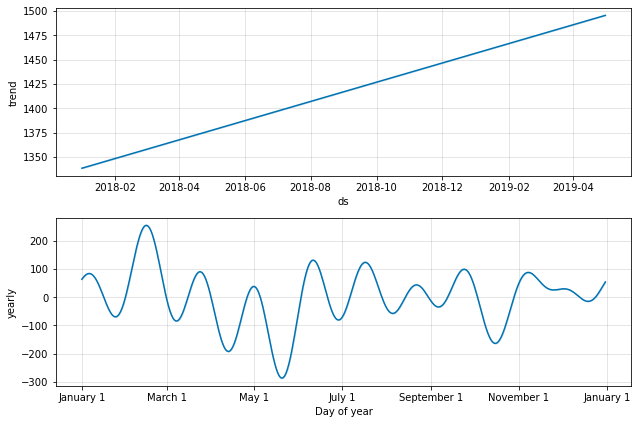

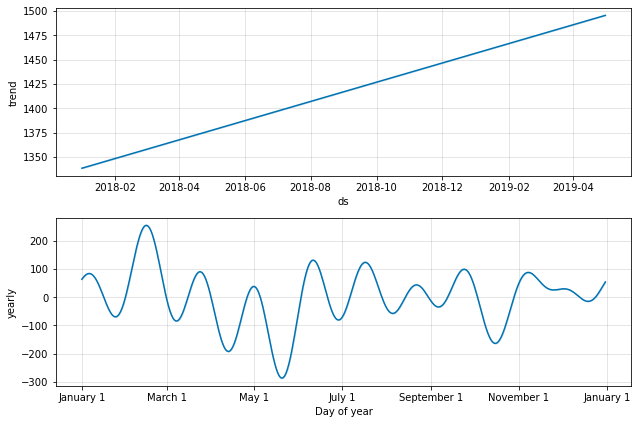

In [1020]:
forecast = m.predict(df_valid2[["report_date", "value_rub"]].rename(columns={"report_date": "ds"}))
df_valid_sum["Forecast_Prophet"] = forecast.yhat.values
m.plot_components(forecast)

<AxesSubplot:xlabel='report_date'>

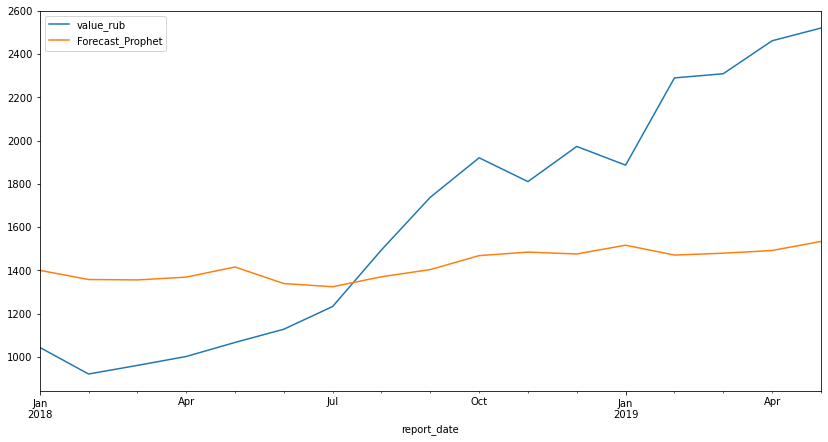

In [1021]:
df_valid_sum[["value_rub", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [1022]:
## This doesn't look promising - we must try other models

In [1023]:
df_train = sector_sum

In [1024]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Value of desposit money in rubles variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe series seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe series isn't stationary")

In [1025]:
## Looking into standard ARIMA params.

Results of Dickey-Fuller Test:
Test Statistic                   1.0396
p-value                          0.9947
Lags Used                        1.0000
Number of Observations Used    146.0000
Critical Value (1%)             -3.4760
Critical Value (5%)             -2.8815
Critical Value (10%)            -2.5774
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The series isn't stationary


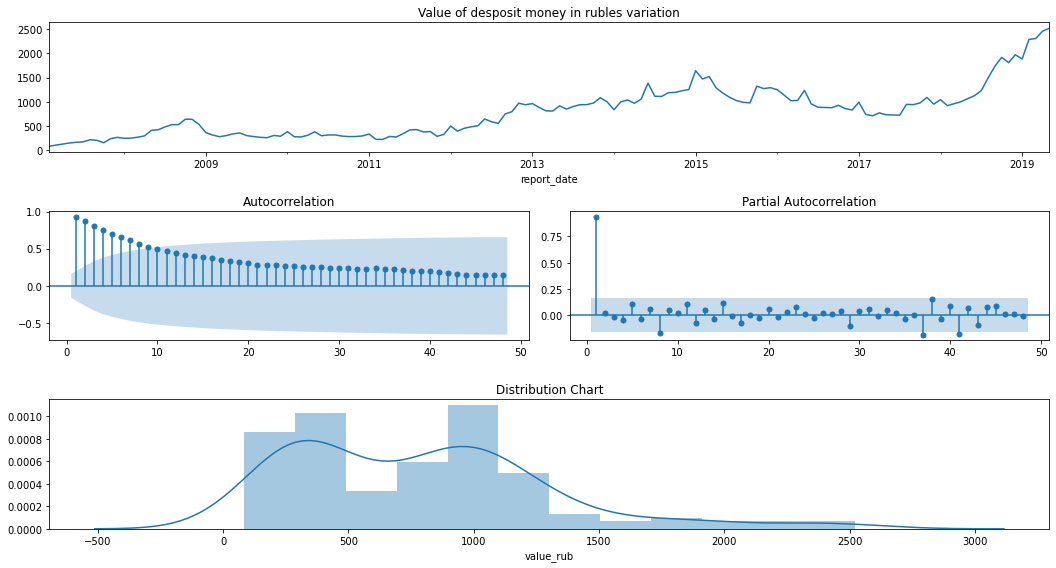

In [1026]:
check_stationarity(df_train['value_rub'])

In [1027]:
df_train['value_rub_boxcox'], lmbda = scs.boxcox(df_train.value_rub)

Results of Dickey-Fuller Test:
Test Statistic                  -2.3244
p-value                          0.1642
Lags Used                        0.0000
Number of Observations Used    135.0000
Critical Value (1%)             -3.4797
Critical Value (5%)             -2.8832
Critical Value (10%)            -2.5783
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The series isn't stationary


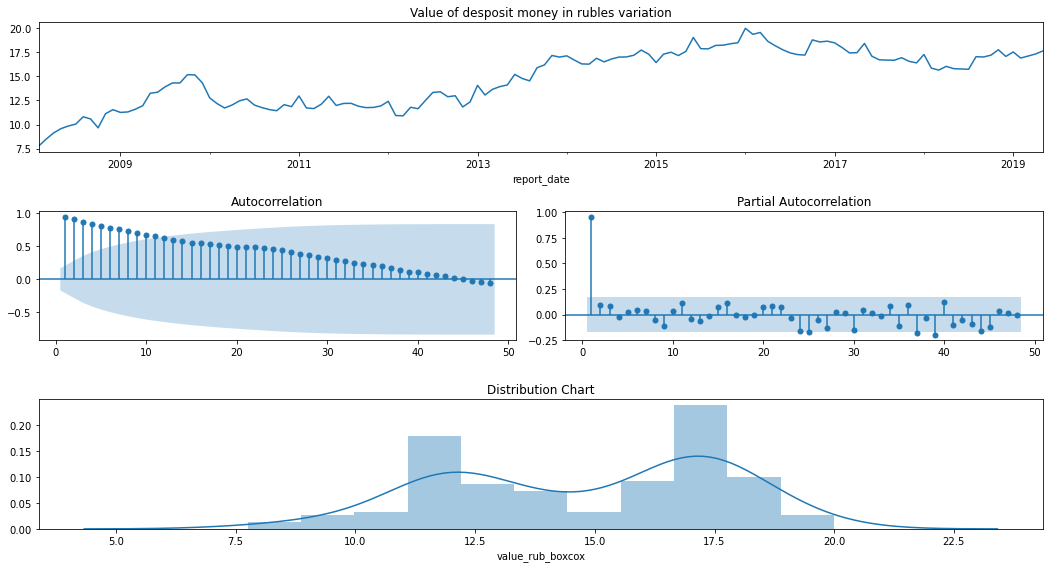

In [1028]:
check_stationarity(df_train['value_rub_boxcox'].shift(12).dropna())

In [1029]:
df_train['value_rub_boxcox_diff'] = df_train.value_rub_boxcox - df_train.value_rub_boxcox.shift(1)

Results of Dickey-Fuller Test:
Test Statistic                 -13.2220
p-value                          0.0000
Lags Used                        0.0000
Number of Observations Used    146.0000
Critical Value (1%)             -3.4760
Critical Value (5%)             -2.8815
Critical Value (10%)            -2.5774
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


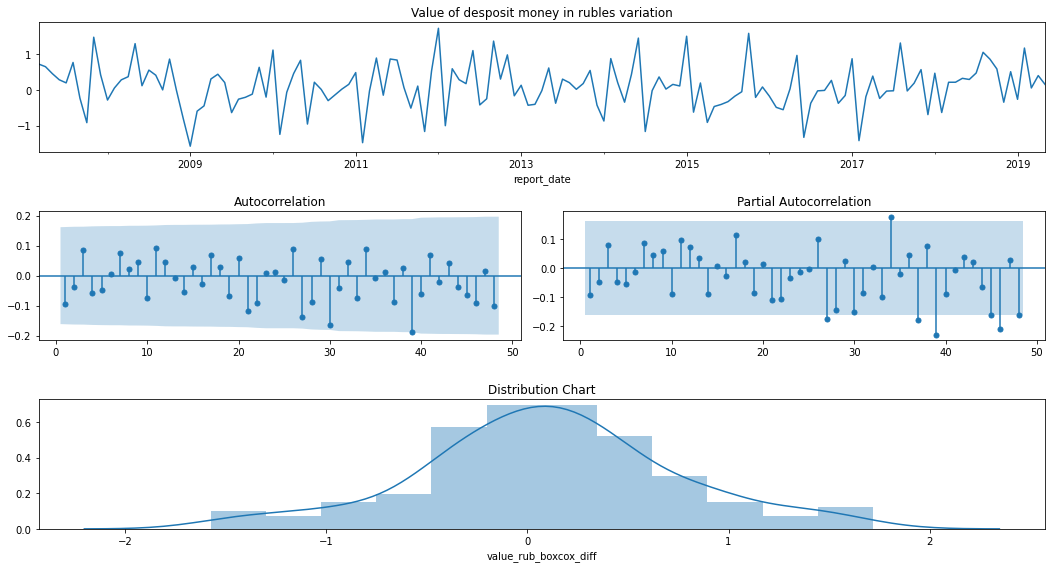

In [1030]:
check_stationarity(df_train['value_rub_boxcox_diff'].dropna())

In [1031]:
df_train = df_train.drop(columns='value_rub_boxcox_diff')

In [1032]:
## Looks like we have p = 1, q = 1, P = 4, but we will run additional tests

In [1033]:
df_train = df_train.drop(columns='report_date')

In [1034]:
## Check if there are any 0 values - Box-Cox operation criterion
df_train[df_train['value_rub_boxcox'] == 0].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [value_rub, value_rub_boxcox]
Index: []>

In [1035]:
# setting initial values and some bounds for them
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)
s = 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [1036]:
def optimizeSARIMA_crit(train_rub, parameters_list, penalty_criterion, d, D, s):
    """
        Return dataframe with parameters and corresponding penalty criterion
        
        train_rub - series with our rubles.
        
        parameters_list - list with (p, q, P, Q) tuples
        penalty_criterion - AIC/BIC/HQIC
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_penalty_criterion = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train_rub, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        penalty = model.aic if penalty_criterion == 'aic' else model.bic
        # saving best model, AIC, BIC or HQIC and parameters
        if penalty < best_penalty_criterion:
            best_model = model
            best_penalty_criterion = penalty
            best_param = param
        results.append([param, penalty])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', str(penalty_criterion)]
    # sorting in ascending order, the lower - the better
    result_table = result_table.sort_values(by=str(penalty_criterion), ascending=True).reset_index(drop=True)
    
    return result_table

In [1037]:
result_table = optimizeSARIMA_crit(df_train.value_rub_boxcox, parameters_list, 'aic', d, D, s)

In [1038]:
result_table.head()

,parameters,aic
0,"(0, 0, 4, 1)",288.569824
1,"(0, 1, 4, 1)",290.373454
2,"(1, 0, 4, 1)",290.403395
3,"(0, 0, 4, 0)",290.965316
4,"(0, 0, 0, 1)",291.667800


In [1039]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train.value_rub_boxcox, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     value_rub_boxcox   No. Observations:                  148
Model:             SARIMAX(0, 1, 0)x(4, 1, [1], 12)   Log Likelihood                -138.285
Date:                              Sat, 01 Aug 2020   AIC                            288.570
Time:                                      14:11:49   BIC                            306.001
Sample:                                  02-01-2007   HQIC                           295.654
                                       - 05-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4384      0.146     -3.010      0.003      -0.724      -0.153
ar.S.L24      -0.42

Results of Dickey-Fuller Test:
Test Statistic                  -8.9411
p-value                          0.0000
Lags Used                        1.0000
Number of Observations Used    121.0000
Critical Value (1%)             -3.4856
Critical Value (5%)             -2.8857
Critical Value (10%)            -2.5797
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


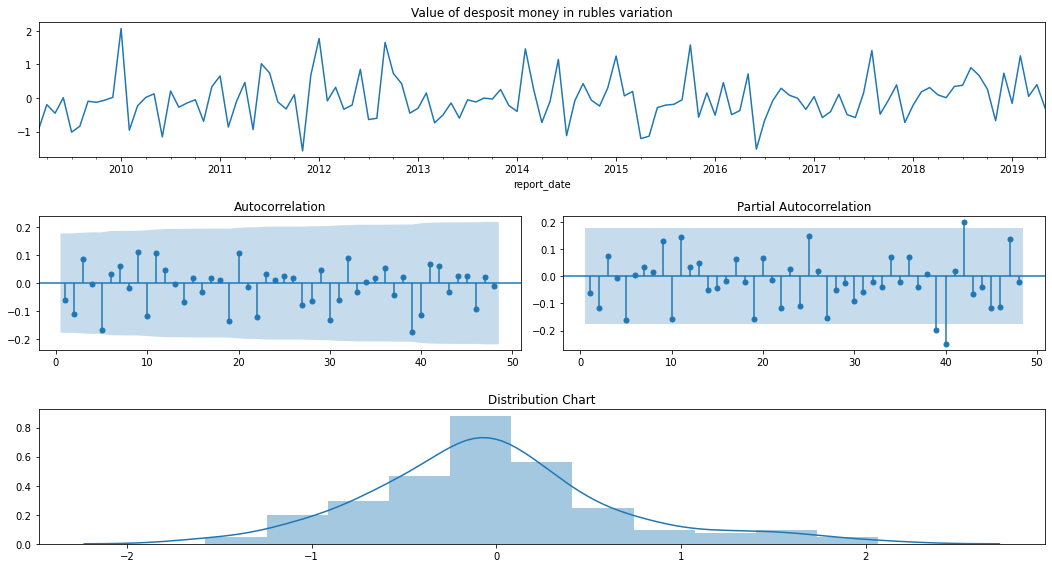

In [1040]:
check_stationarity(best_model.resid[24+1:])

In [1041]:
df_train['model'] = invboxcox(best_model.fittedvalues, lmbda)

In [1042]:
def SARIMAprep(df, column, model, n_steps):
    """
        prepares data from SARIMA plot
        
        series - dataset series with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = pd.DataFrame(df[column]).copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = pd.DataFrame(data.arima_model.append(forecast))
    forecast.columns = ['forecast']
   
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    # adding additional data for plot
    data = pd.concat([data, forecast], ignore_index=False, axis=1)
    data.index.name = 'report_date'
    data['value_rub'] = df['value_rub']
    data['forecast'] = invboxcox(forecast, lmbda)
    
    return data, error

In [1043]:
data, error, = SARIMAprep(df_train, 'value_rub_boxcox', best_model, 12)

In [1044]:
data = data.reset_index()

In [1045]:
def PlotSARIMA(data, error): 
    """
        Plots SARIMA with ALTAIR
        
        data - data set with 'report_date', 'value_rub' and 'forecast' columns
        error - mean absolute pecentage error
    """
    
    base = alt.Chart(data).transform_calculate(
    legend1="'value_rub'",
    legend2="'forecast'",

    )
    scale = alt.Scale(domain=["value_rub", "forecast"], range=['orange', 'blue'])

    # timeseries plot of ruble deposits in orange colour
    line1 = base.mark_line(color='orange').encode(
    x = 'report_date:T',
    y = 'value_rub:Q',
    color=alt.Color('legend1:N', scale=scale, title=''),
    )

    # timeseries plot of ruble deposits forecast in blue colour
    line2 = base.mark_line(color='blue').encode(
    x = 'report_date:T',
    y = 'forecast:Q',
    color=alt.Color('legend2:N', scale=scale, title='')
    )

    text = line1.mark_text(
        align='left',
        baseline='middle',
        dx=3
    )   

    return (line1 + line2 + text).properties(
        title={"text":["Mean Absolute Percentage Error: {0:.2f}%".format(error)],
               "fontSize":15,
               "fontWeight": 'bold',
               "font":'Courier New',},
        height=300, width=900
    ).interactive()
    

In [1046]:
PlotSARIMA(data, error)

alt.LayerChart(...)

In [1073]:
df_train_sum = data[data.report_date < "2018-01-01"].set_index("report_date", drop=True, inplace=False)
df_valid_sum = data[data.report_date >= "2018-01-01"].set_index("report_date", drop=True, inplace=False)

In [1074]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    # Forecasting one period ahead in the validation set
    for month in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[month])
        
    return prediction

In [1075]:
df_valid_sum['Pred'] = walk_forward(df_train_sum['actual'], df_valid_sum['actual'], ((p,d,q),(P,D,Q,s),'c'))

In [1078]:
df_valid_sum['Pred_ruble'] = invboxcox(df_valid_sum.Pred, lmbda)

In [1079]:
mape_pred = mean_absolute_percentage_error(df_valid_sum['actual'], df_valid_sum['Pred'])
print(f"The MAPE of the SARIMA model was {round(mape_pred,2)}%")

The MAPE of the SARIMA model was 2.29%


In [1080]:
df_valid_sum['error'] = df_valid_sum['value_rub'] - df_valid_sum['Pred_ruble']

In [1081]:
df_valid_sum = df_valid_sum.drop(columns=['actual', 'forecast' ,'arima_model', 'Pred'])

In [1084]:
df_valid_sum.head()

,value_rub,Pred_ruble,error
report_date,,,
2018-01-01,1044.004018,1069.592317,-25.588299
2018-02-01,920.735163,859.432852,61.302311
2018-03-01,960.465366,887.841989,72.623377
2018-04-01,1001.639815,978.498491,23.141324
2018-05-01,1066.606772,1056.501908,10.104864


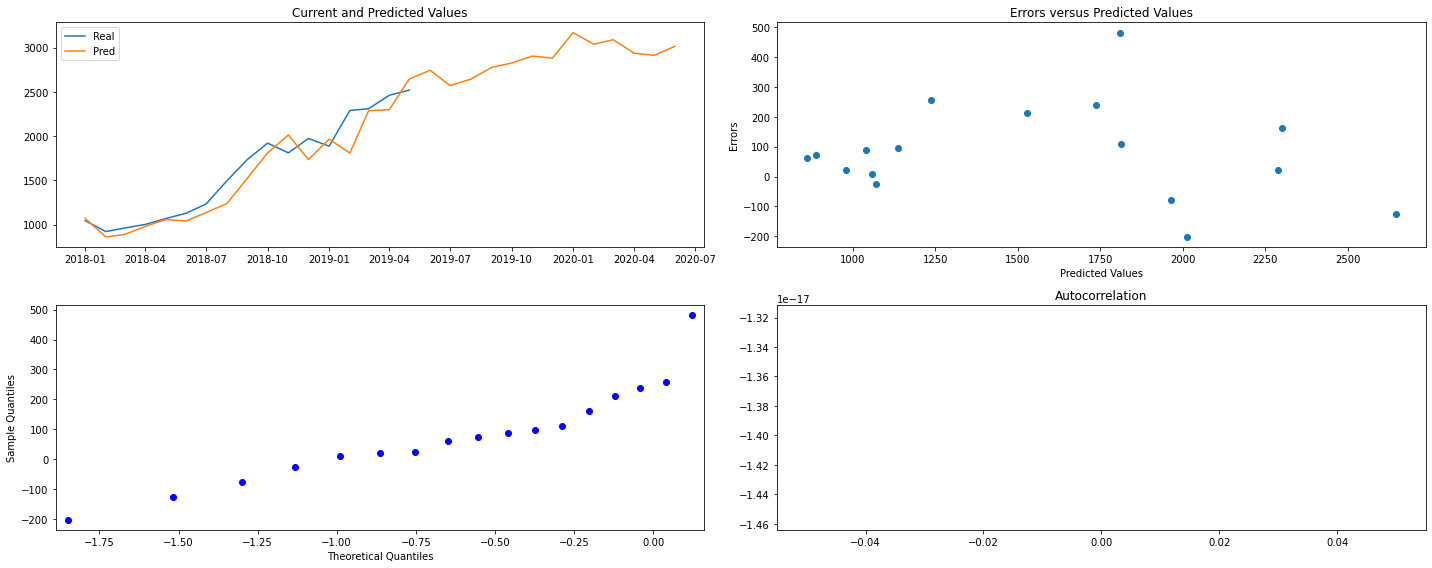

In [1083]:
plot_error(df_valid_sum)

In [ ]:
##Holt-Winters

In [1085]:
df_sum = data.copy().set_index("report_date", drop=True, inplace=False).dropna()

In [1086]:
df_sum.head()

,actual,arima_model,forecast,value_rub
report_date,,,,
2008-03-01,11.587348,12.029612,302.235295,268.817688
2008-04-01,11.954198,12.233557,318.674650,296.323779
2008-05-01,13.244462,12.405887,333.091411,410.506700
2008-06-01,13.358644,13.524953,439.247124,422.026951
2008-07-01,13.909390,13.552449,442.145139,481.109778


In [1087]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [1088]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [1089]:
def timeseriesCVscore(params, series, loss_function=mean_squared_log_error, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=4) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [1090]:
df_data = df_sum.actual[:-13] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(df_data, mean_squared_error), 
               method="TNC", bounds = ((0, 2), (0, 2), (0, 2))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(df_data, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24, scaling_factor = 2)
model.triple_exponential_smoothing()

0.20379625888430775 0.18924119848113008 0.33926665483947294


In [1091]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    model_result = invboxcox(np.array(model.result), lmbda)
    model_LowerBond = invboxcox(np.array(model.LowerBond), lmbda)
    model_UppoerBond = invboxcox(np.array(model.UpperBond), lmbda)
    series_values = invboxcox(series.values, lmbda)
    
    plt.figure(figsize=(20, 10))
    plt.plot(model_result, label = "Model")
    plt.plot(series_values, label = "Actual")
    error = mean_absolute_percentage_error(series_values, model_result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series_values<model_LowerBond[:len(series)]] = \
            series_values[series_values<model_LowerBond[:len(series)]]
        anomalies[series_values>model_UppoerBond[:len(series)]] = \
            series_values[series_values>model_UppoerBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model_UppoerBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model_LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model_result)), y1=model_UppoerBond, 
                         y2=model_LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model_LowerBond), ymax=max(model_UppoerBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model_result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

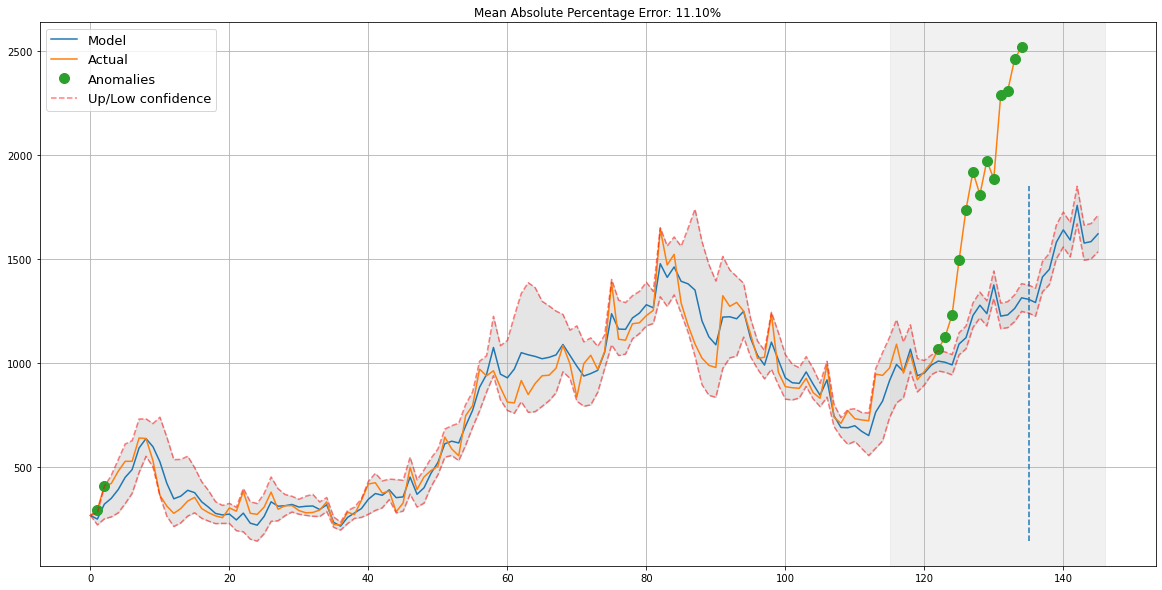

In [1092]:
plotHoltWinters(df_sum.actual, plot_anomalies=True, plot_intervals = True)

In [988]:
## Conclusion, we can choose SARIMAX if we have time to build the model, and Holt-Winters if we don't